## Data
Specify the data path in your computer.

In [1]:
import json

WORD2VEC_DATA_PATH = "SOMEWHERE_ON_YOUR_COMPUTER/GoogleNews-vectors-negative300.bin.gz"

DEFINITIONAL_PAIRS_PATH = "data/definitional_pairs.json"
PROFESSIONS_DATA_PATH = "data/professions.json"
EQUALIZE_PAIRS_PATH = "data/equalize_pairs.json"
GENDER_SPECIFIC_DATA_PATH = "data/gender_specific_full.json"

def read_json(data_path: str):
    return json.load(open(data_path, 'r'))

definitional_pairs = read_json(DEFINITIONAL_PAIRS_PATH)
professions = read_json(PROFESSIONS_DATA_PATH)
equalize_pairs = read_json(EQUALIZE_PAIRS_PATH)
gender_specific = set(read_json(GENDER_SPECIFIC_DATA_PATH))

## 3 Preliminaries

### Embedding
Unless otherwise stated, the embedding we refer to in this paper is the aforementioned w2vNEWS embedding, a d = 300-dimensional word2vec embedding. In particular, we downloaded the pre-trained embedding on the Google News corpus (https://code.google.com/archive/p/word2vec/), and normalized each word to unit length as is common.

In [2]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format(WORD2VEC_DATA_PATH, limit=100000, binary=True)
model.init_sims(replace=True) # this normalizes the vectors to be the unit length

## 4 Gender stereotypes in word embeddings
### Occupational stereotypes.
Figure 1 lists the occupations that are closest to _she_ and to _he_ in the w2vNEWS embeddings

In [3]:
from typing import List
from collections import Counter

def get_most_similar_words_with(target_word: str, query_words: List[str], model: KeyedVectors, top_k: int = 12):
    similarities = Counter()
    for word in query_words:
        similarities[word] = model.similarity(word, target_word)
    return similarities.most_common(top_k)

In [4]:
occupations = [word for word, _, _ in professions if word not in gender_specific]

Figure 1: The most extreme occupations as projected on to the _she−he_ gender direction on g2vNEWS.  
Occupations such as _businesswoman,_ where gender is suggested by the orthography, were excluded.

In [5]:
get_most_similar_words_with("she", occupations, model)

[('homemaker', 0.398446),
 ('receptionist', 0.38378775),
 ('hairdresser', 0.37579125),
 ('nurse', 0.3694259),
 ('registered_nurse', 0.35921058),
 ('confesses', 0.34259766),
 ('paralegal', 0.32918584),
 ('housekeeper', 0.32787254),
 ('clerk', 0.31268093),
 ('nanny', 0.2962942),
 ('dancer', 0.29316145),
 ('bookkeeper', 0.29155013)]

In [6]:
get_most_similar_words_with("he", occupations, model)

[('soft_spoken', 0.35008138),
 ('protege', 0.2988804),
 ('politician', 0.296749),
 ('sportsman', 0.2909003),
 ('confesses', 0.28672272),
 ('actor', 0.2804842),
 ('doctor', 0.2743739),
 ('ballplayer', 0.27259606),
 ('carpenter', 0.27101207),
 ('policeman', 0.27044824),
 ('cabbie', 0.26954412),
 ('priest', 0.2612976)]

### Analogies exhibiting stereotypes.
Figure 2: Analogy examples

In [7]:
model.most_similar(positive=['he', 'housewife'], negative=['she'])

[('businessman', 0.5175440311431885),
 ('schoolteacher', 0.4978965222835541),
 ('shopkeeper', 0.47978055477142334),
 ('laborer', 0.4709293842315674),
 ('man', 0.4704824686050415),
 ('taxi_driver', 0.46757081151008606),
 ('carpenter', 0.45320457220077515),
 ('farmer', 0.4418044984340668),
 ('hero', 0.4327959418296814),
 ('lad', 0.42618119716644287)]

In [8]:
model.most_similar(positive=['he', 'softball'], negative=['she'])

[('baseball', 0.6792116165161133),
 ('football', 0.5886937379837036),
 ('Softball', 0.5582471489906311),
 ('basketball', 0.5443937182426453),
 ('soccer', 0.539060115814209),
 ('Baseball', 0.5169258117675781),
 ('volleyball', 0.5008956789970398),
 ('batting_cages', 0.49255841970443726),
 ('Cal_Ripken', 0.4907674491405487),
 ('junior_varsity', 0.48719659447669983)]

### Indirect gender bias
To test this indirect gender bias, we take pairs of words that are gender-neutral, for example _softball_ and _football._ We project all the occupation words onto the _softball_ − _football_ direction and looked at the extremes words, which are listed in Figure 3.

In [9]:
import numpy as np
def project_between_two_points(vec: np.ndarray, a: np.ndarray, b: np.ndarray):
    """
    The output is the cooordinate between the two points a and b.
    The output 0 means the center of a and b, 1 means b, -1 means a.
    """
    new_origin = (a + b) / 2
    new_axis = b - new_origin
    new_axis_unit_length = np.linalg.norm(new_axis)
    new_axis /= new_axis_unit_length
    vec_from_new_origin = vec - new_origin
    return vec_from_new_origin.dot(new_axis) / new_axis_unit_length

In [10]:
plotted_occupations = Counter()
for word in occupations:
    plotted_occupations[word] = project_between_two_points(model[word], model['softball'], model['baseball'])

In [11]:
# close to baseball
plotted_occupations.most_common()[:10]

[('ballplayer', 0.8659656),
 ('major_leaguer', 0.8154428),
 ('philosopher', 0.46584326),
 ('broadcaster', 0.45277196),
 ('barber', 0.4252447),
 ('sportswriter', 0.39869338),
 ('inventor', 0.39034843),
 ('industrialist', 0.36241075),
 ('financier', 0.35488385),
 ('mathematician', 0.347327)]

In [12]:
# close to softball
plotted_occupations.most_common()[-10:]

[('treasurer', -0.31703272),
 ('valedictorian', -0.3229477),
 ('bookkeeper', -0.34015563),
 ('goalkeeper', -0.35132754),
 ('homemaker', -0.36078987),
 ('secretary', -0.37140495),
 ('vocalist', -0.38780102),
 ('receptionist', -0.44150662),
 ('registered_nurse', -0.45217896),
 ('soloist', -0.46549433)]

## 5 Geometry of Gender and Bias
### 5.1 Identifying the gender subspace
To identify the gender subspace, we took the ten gender pair difference vectors and computed its principal components (PCs). As Figure 6 shows, there is a single direction that explains the majority of variance in these vectors. 

In [13]:
import numpy as np

def get_normalized_direction(vec1, vec2):
    center = (vec1 + vec2) / 2
    return [vec1 - center, vec2 - center]

gender_directions = []
for f, m in definitional_pairs:
    gender_directions += get_normalized_direction(model[f], model[m])

In [14]:
import random

def get_random_vector(model):
    vocab_size = len(model.vocab)
    idx = random.randint(0, vocab_size-1)
    return model.vectors[idx]

random_directions = []
for _ in range(len(definitional_pairs)):
    random_directions += get_normalized_direction(get_random_vector(model), get_random_vector(model))

The first eigenvalue is significantly larger than the rest.

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(gender_directions)
plt.bar(range(n_components), pca.explained_variance_ratio_)
g = pca.components_[0]
g /= np.linalg.norm(g)

Note that, from the randomness in a finite sample of ten noisy vectors, one expects a decrease in eigenvalues.

<BarContainer object of 10 artists>

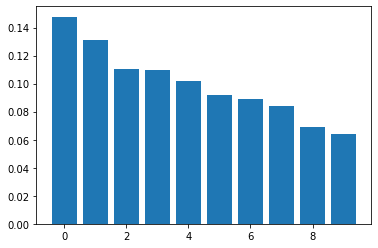

In [16]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(random_directions)
plt.bar(range(n_components), pca.explained_variance_ratio_)

### 5.2 Direct bias

In [17]:
def compute_direct_bias(neutral_embeddings: List[np.ndarray], g: np.ndarray, c: float=1.0):
    neutral_embeddings = np.stack(neutral_embeddings)
    cosine_sims = neutral_embeddings.dot(g)  # assume the vectors are normalized
    return (abs(cosine_sims) ** c).sum() / len(neutral_embeddings)

For example, in w2vNEWS, if we take N to be the set of 327 occupations, then DirectBias1 = 0.08, which confirms that many occupation words have substantial component along the gender direction.

In [18]:
profession_words = [word for word, _, _ in professions]
profession_vectors = [model[w] for w in profession_words]
compute_direct_bias(profession_vectors, g)

0.08050745259425576

In [19]:
# The direct bias of gender specific words
gender_vectors = []
for f, m in definitional_pairs:
    gender_vectors.append(model[f])
    gender_vectors.append(model[m])
compute_direct_bias(gender_vectors, g)

0.2922147829329026

In [20]:
# The direct bias of random words
random_vectors = [get_random_vector(model) for _ in range(1000)]
compute_direct_bias(random_vectors, g)

0.05302191235665289

### 5.3 Indirect bias

In [21]:
def compute_indirect_bias(w, v, g):
    dot_product = w.dot(v)
    
    def compute_orthogonal(vec, direction):
        return vec - vec.dot(direction) * direction

    orth_w = compute_orthogonal(w, g)
    orth_v = compute_orthogonal(v, g)
    
    non_gender_sim = orth_w.dot(orth_v) / (np.linalg.norm(orth_w) * np.linalg.norm(orth_v))
    
    return (dot_product - non_gender_sim) / dot_product

Words such as _receptionist,_ _waitress_ and _homemaker_ are closer to
_softball_ than _football,_ and the β’s between these words and _softball_ is substantial.

In [22]:
compute_indirect_bias(model["receptionist"], model['softball'], g)

0.6723426377668333

In [23]:
compute_indirect_bias(model["waitress"], model['softball'], g)

0.3178421346299225

In [24]:
compute_indirect_bias(model["homemaker"], model['softball'], g)

0.38374104380558116

## 6 Debiasing algorithms
The first step, called Identify gender subspace, is to identify a direction (or, more generally, a subspace) of the embedding that captures the bias.

In [25]:
from typing import List, Tuple
import json
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Identify gender subspace
def get_gender_subspace(model: KeyedVectors, defining_sets: List[Tuple[str, str]], k: int):
    
    def get_normalized_direction(vec1, vec2):
        center = (vec1 + vec2) / 2
        return [vec1 - center, vec2 - center]
    
    direction_vectors = []
    for f, m in defining_sets:
        direction_vectors += get_normalized_direction(model[f], model[m])

    pca = PCA(n_components=k)
    pca.fit(gender_directions)
    return pca.components_

In [26]:
import copy

# Step 2a: Hard de-biasing

def project(vec, B):
    subspace_magnitude = vec.dot(B.T)
    vec_projected = subspace_magnitude.dot(B)
    return vec_projected

def neutralize(model, B, stop_list = None, in_place = False):
    
    if not in_place:
        model = copy.deepcopy(model)
    
    if stop_list is not None:
        stop_list_indices = [model.vocab[word].index for word in stop_list]
        stop_word_embeddings = model.vectors[stop_list_indices] 

    all_vectors_projected = project(model.vectors, B)
    model.vectors -= all_vectors_projected
    model.vectors /= np.linalg.norm(model.vectors, axis=1)[:, np.newaxis, ]
    if stop_list is not None:
        model.vectors[stop_list_indices] = stop_word_embeddings
    model.init_sims(replace=True)
    return model

def equalize(model, B, equality_sets, in_place: bool = False):
    if not in_place:
        model = copy.deepcopy(model)

    for w1, w2 in equality_sets:
        mean = (model[w1] + model[w2]) / 2
        mean_projected = project(mean, B)
        mean_neutral = mean - mean_projected
        w1_projected = project(model[w1], B)
        w2_projected = project(model[w2], B)
        
        w1_diff = w1_projected - mean_projected
        w2_diff = w2_projected - mean_projected
        
        model[w1] = mean_neutral + np.sqrt(1 - (mean_neutral**2).sum()) * w1_diff / np.linalg.norm(w1_diff)
        model[w2] = mean_neutral + np.sqrt(1 - (mean_neutral**2).sum()) * w2_diff / np.linalg.norm(w2_diff)
        
    return model

In [27]:
equality_words = []
for s in equalize_pairs:
    equality_words += s

In [29]:
B = get_gender_subspace(model, definitional_pairs, 3)
debiased = neutralize(model, B, equality_words)
debiased = equalize(debiased, B, equalize_pairs)

In [30]:
model.most_similar(positive=['woman', 'computer_programmer'], negative=['man'])

[('homemaker', 0.5627118945121765),
 ('housewife', 0.5105046033859253),
 ('graphic_designer', 0.5051802396774292),
 ('schoolteacher', 0.497949481010437),
 ('businesswoman', 0.49348917603492737),
 ('paralegal', 0.49255111813545227),
 ('registered_nurse', 0.4907974600791931),
 ('saleswoman', 0.4881627559661865),
 ('electrical_engineer', 0.4797726571559906),
 ('mechanical_engineer', 0.4755399525165558)]

In [31]:
debiased.most_similar(positive=['woman', 'computer_programmer'], negative=['man'])

[('mechanical_engineer', 0.5537900328636169),
 ('electrical_engineer', 0.5340908765792847),
 ('businesswoman', 0.49205249547958374),
 ('engineer', 0.47469794750213623),
 ('carpenter', 0.45996394753456116),
 ('programmer', 0.45308178663253784),
 ('graphic_designer', 0.4483581781387329),
 ('homemaker', 0.4454195499420166),
 ('schoolteacher', 0.44264787435531616),
 ('machinist', 0.44043925404548645)]

In [32]:
word = "homemaker"
print("Before")
print(model.similarity(word, "man"))
print(model.similarity(word, "woman"))
print("After")
print(debiased.similarity(word, "man"))
print(debiased.similarity(word, "woman"))

Before
0.2159463
0.40326244
After
0.30415044714199124
0.30415044521171064
